In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import math
import warnings
from matplotlib import rcParams

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow import keras
from tensorflow.python.keras.layers import Dropout, Dense, LSTM,Activation,GRU,SimpleRNN
from tensorflow.python.keras import backend as K

from keras import regularizers
from keras.losses import mean_squared_error

warnings.filterwarnings("ignore")

In [3]:
data_init = pd.read_excel("shujuji.xlsx")

x,y = data_init.iloc[:,1:6],data_init.iloc[:,-1]

In [4]:
data_init

,id,temperature,flow,PH,data_in_COD,NH3_N,total_nitrogen,data_out_COD
0,1,33.9,379.4386,5.67,362.0491,15.80,7.32,22.1080
1,2,44.4,374.3369,5.03,233.2150,21.45,12.93,44.0340
2,3,40.2,290.7272,7.11,353.9716,19.25,10.85,39.5237
3,4,44.3,388.9247,6.56,332.8261,10.97,11.61,21.0939
4,5,38.2,305.0809,5.75,391.5420,17.29,14.84,47.0766
...,...,...,...,...,...,...,...,...
255,256,27.6,301.4990,5.52,313.3165,24.55,12.90,28.0662
256,257,34.3,218.0500,5.04,275.7860,21.77,10.15,27.1045
257,258,24.1,245.5469,7.47,363.2505,22.09,11.10,33.5931
258,259,48.7,233.4377,6.17,309.1838,20.07,10.54,41.9565


In [5]:
data_init.iloc[:,1:].agg(['min','max', "mean"])

,temperature,flow,PH,data_in_COD,NH3_N,total_nitrogen,data_out_COD
min,18.000,200.711800,5.000000,200.655600,8.260000,5.0400,20.224100
max,53.000,499.845400,8.000000,399.979200,29.870000,15.0000,49.977700
mean,35.585,342.732885,6.559346,301.495241,19.055923,9.8895,34.820523


In [6]:
data_init.iloc[:,1:-1]

,temperature,flow,PH,data_in_COD,NH3_N,total_nitrogen
0,33.9,379.4386,5.67,362.0491,15.80,7.32
1,44.4,374.3369,5.03,233.2150,21.45,12.93
2,40.2,290.7272,7.11,353.9716,19.25,10.85
3,44.3,388.9247,6.56,332.8261,10.97,11.61
4,38.2,305.0809,5.75,391.5420,17.29,14.84
...,...,...,...,...,...,...
255,27.6,301.4990,5.52,313.3165,24.55,12.90
256,34.3,218.0500,5.04,275.7860,21.77,10.15
257,24.1,245.5469,7.47,363.2505,22.09,11.10
258,48.7,233.4377,6.17,309.1838,20.07,10.54


In [8]:
# # 构造 x_train and y_train
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data_init) # 数据归一化[0,1]
# #划分比例 8:2
# # train = scaled_data[:188]
# # test = scaled_data[188:]
# # train_x,train_y = train[:,1:6],train[:,-1]
# # test_x,test_y = test[:,1:6],test[:,-1]
# x_data = scaled_data[:,1:6]
# y_data = scaled_data[:,-1]

# 数据归一化
scaler_input = MinMaxScaler(feature_range=(0, 1))

scaler_output = MinMaxScaler(feature_range=(0, 1))

data_input = data_init.iloc[:,1:-1]
data_output = np.array(data_init.iloc[:,-1]).reshape(-1, 1)


x_data = scaler_input.fit_transform(data_input) # 数据归一化[0,1]  //scaler_input.fit_transform返回 numpy.ndarray 类型的数据
y_data = scaler_output.fit_transform(data_output) # 数据归一化[0,1]




In [9]:
time_steps = 4

In [10]:
len(x_data)

260

In [11]:
xx_data = []
yy_data = []

# 测试集：csv表格中前187条数据
# 利用for循环，遍历整个训练集，提取训练集中连续5条数据作为输入特征x_train，第6条的数据作为标签
for i in range(time_steps, len(x_data)):
    xx_data.append(x_data[i - time_steps:i, :].tolist())
    yy_data.append(y_data[i])
    
yy_data = np.array(yy_data)



In [12]:
np.array(xx_data).shape,np.array(yy_data).shape

((256, 4, 6), (256, 1))

In [13]:
type(xx_data),len(xx_data)

(list, 256)

In [14]:
train_X_nn, train_y_nn = np.array(xx_data)[:184,:], yy_data[:184]
test_X_nn, test_y_nn = np.array(xx_data)[184:,:], yy_data[184:]

In [15]:
x_train,y_train = np.array(train_X_nn),np.array(train_y_nn)

In [16]:
x_train.shape,y_train.shape

((184, 4, 6), (184, 1))

In [17]:
x_test,y_test = np.array(test_X_nn),np.array(test_y_nn)
x_test.shape,y_test.shape

((72, 4, 6), (72, 1))

In [18]:
def show_data(test_y,predict_y,title):
    plt.figure(figsize=(10,8),dpi=100)
    x = [i for i in range(test_y.shape[0])]
    plt.plot(x, test_y, color='navy',lw = 2, label='Actual data')
    plt.plot(x, predict_y, color='c',lw = 2, label='Predict data')
    x_label = [i for i in x[::5]]
    
    y_label = [j for j in range(0,500,50)]
    plt.yticks(y_label)
    plt.xticks(x_label)
    plt.xlabel('Time/d')
    plt.ylabel('COD')
    plt.title(title)
    plt.legend()
    plt.show()

In [19]:

model_LG = tf.keras.Sequential([
    LSTM(128,input_shape=(x_train.shape[1], x_train.shape[2]),return_sequences=True),
     Dropout(0.2),
    LSTM(128,return_sequences=True),
    Dropout(0.2),
       GRU(64,return_sequences=True),
    Dropout(0.2),
    GRU(64),   
    Dropout(0.1),
    Dense(units=1,activation = 'sigmoid')
])


opt_LG = tf.keras.optimizers.Adam(lr=0.02)
rmse = tf.keras.metrics.RootMeanSquaredError(name='rmse')
#rmse3.reset_states()
model_LG.compile(optimizer=opt_LG,
              loss= 'mse',metrics=['mae',rmse,'mse','mape'])

history_LG = model_LG.fit(x_train, y_train, batch_size=128, epochs=150, validation_data=(x_test, y_test), validation_freq=1)
model_LG.summary() #打印



Epoch 1/150
2/2 [==============================] - 12s 1s/step - loss: 0.0736 - mae: 0.2319 - rmse: 0.2713 - mse: 0.0736 - mape: 120.5716 - val_loss: 0.2203 - val_mae: 0.3919 - val_rmse: 0.4694 - val_mse: 0.2203 - val_mape: 11814073.0000
Epoch 2/150
2/2 [==============================] - 0s 55ms/step - loss: 0.1496 - mae: 0.3111 - rmse: 0.3867 - mse: 0.1496 - mape: 197.7685 - val_loss: 0.0799 - val_mae: 0.2456 - val_rmse: 0.2827 - val_mse: 0.0799 - val_mape: 6613282.5000
Epoch 3/150
2/2 [==============================] - 0s 57ms/step - loss: 0.0799 - mae: 0.2388 - rmse: 0.2826 - mse: 0.0799 - mape: 128.8103 - val_loss: 0.0892 - val_mae: 0.2547 - val_rmse: 0.2987 - val_mse: 0.0892 - val_mape: 5384968.0000
Epoch 4/150
2/2 [==============================] - 0s 57ms/step - loss: 0.0813 - mae: 0.2404 - rmse: 0.2851 - mse: 0.0813 - mape: 99.1353 - val_loss: 0.0849 - val_mae: 0.2530 - val_rmse: 0.2914 - val_mse: 0.0849 - val_mape: 7410916.5000
Epoch 5/150
2/2 [==============================] 

In [20]:
#测试集
model_LG.evaluate(x_test, y_test)
#误差分析
mse = metrics.mean_squared_error(y_test, model_LG.predict(x_test))
mse,math.sqrt(mse),K.sqrt(K.mean(K.square(model_LG.predict(x_test) - y_test))) 

3/3 [==============================] - 0s 5ms/step


(0.1116673734165435,
 0.33416668507878444,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.33416668507878444>)

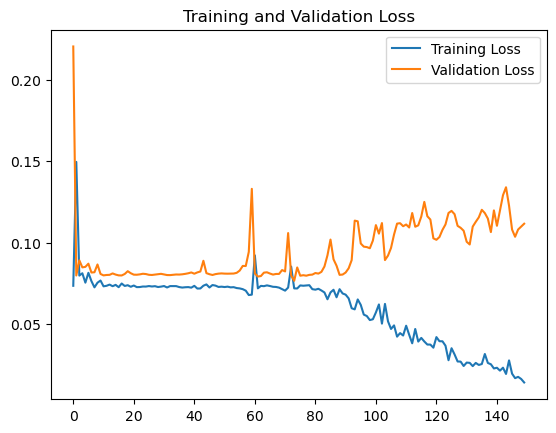

In [22]:
loss = history_LG.history['loss']
val_loss = history_LG.history['val_loss']

plt.style.use('default')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=1)
plt.show()#展示

In [35]:
data = {"loss":history_LG.history['loss'], "val_loss":history_LG.history['val_loss']}
frame = pd.DataFrame(data)
frame.to_csv("GRU_loss.csv", index = False)

In [24]:
y_predict_LSTM_GRU = scaler_output.inverse_transform(model_LG.predict(x_test))

3/3 [==============================] - 0s 4ms/step


In [25]:
y_test1 = scaler_output.inverse_transform(y_test)

In [26]:
# 误差分析
rmse = math.sqrt(metrics.mean_squared_error(y_test1, y_predict_LSTM_GRU)) 

mae=np.sum(np.absolute(y_predict_LSTM_GRU-y_test1))/len(y_test1)
mae2=np.mean(np.absolute(y_predict_LSTM_GRU-y_test1))

mape = np.mean(np.abs((y_test1-y_predict_LSTM_GRU) / y_test1)) * 100
mape2 = np.sum(np.abs((y_predict_LSTM_GRU - y_test1) / y_test1)) * 100/len(y_test1)

print("rmse:",rmse,"mae:",mae,"mae2:",mae2,"mape:",mape,"mape2:",mape2)

rmse: 9.94266182111967 mae: 8.238554926003351 mae2: 8.238554926003351 mape: 26.145683991194197 mape2: 26.145683991194197


In [34]:
data = {"y_test1": [index[0] for index in y_test1.tolist()], "y_predict_LSTM_GRU": [index[0] for index in y_predict_LSTM_GRU.tolist()]}
print(data)
frame = pd.DataFrame(data)
frame.to_csv("GRU_data.csv", index = False)

{'y_test1': [25.5872, 49.7674, 49.1354, 45.7133, 23.8893, 38.4926, 25.3508, 42.8149, 21.8228, 24.1469, 43.9699, 26.6769, 21.1781, 45.7951, 39.8176, 45.6353, 37.8993, 43.0188, 28.2014, 43.3048, 41.3138, 43.2491, 22.3307, 23.3522, 27.3195, 32.3059, 27.322, 22.6818, 21.4972, 38.1243, 35.8833, 44.6618, 33.2272, 35.1209, 39.3255, 40.3839, 31.690899999999996, 30.3252, 48.764, 29.7371, 34.2237, 25.9877, 47.9309, 39.931, 37.5022, 41.3256, 20.2241, 29.6502, 48.264, 38.0447, 30.0919, 25.4234, 22.1134, 28.9857, 34.8451, 43.6294, 25.3052, 33.8639, 33.2145, 34.4399, 43.5968, 34.937, 31.047900000000002, 29.0264, 29.4125, 41.7376, 21.7104, 28.0662, 27.1045, 33.5931, 41.9565, 44.5185], 'y_predict_LSTM_GRU': [37.46166229248047, 30.06342887878418, 28.41136360168457, 35.04378128051758, 25.279041290283203, 41.280853271484375, 40.236053466796875, 37.392765045166016, 36.65447998046875, 32.50861740112305, 34.69743728637695, 29.451616287231445, 39.7978630065918, 37.1099967956543, 34.20901870727539, 29.0970058

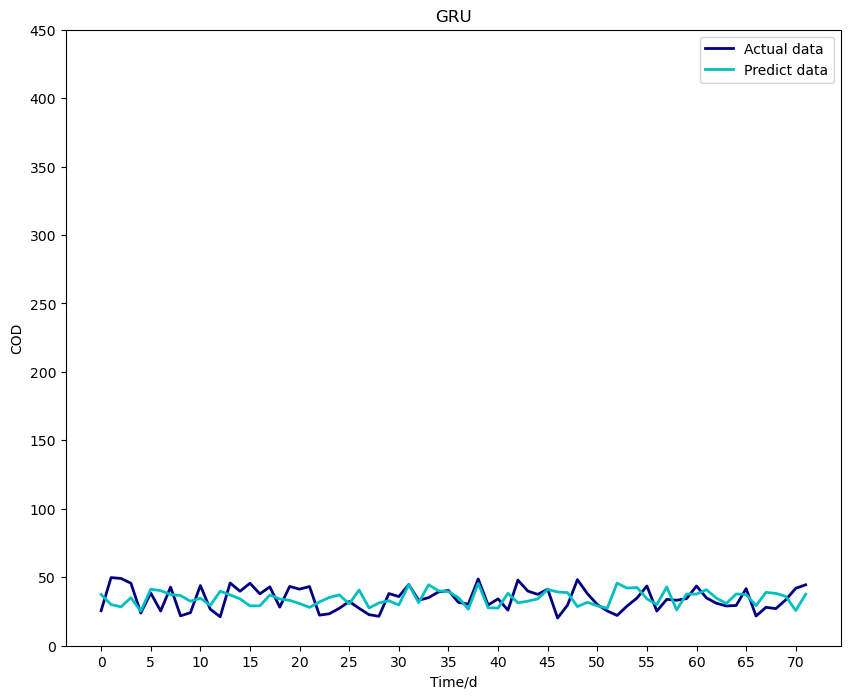

In [28]:
show_data(y_test1,y_predict_LSTM_GRU,"GRU")